# 103.4. Rubin Cutout Service

<div>
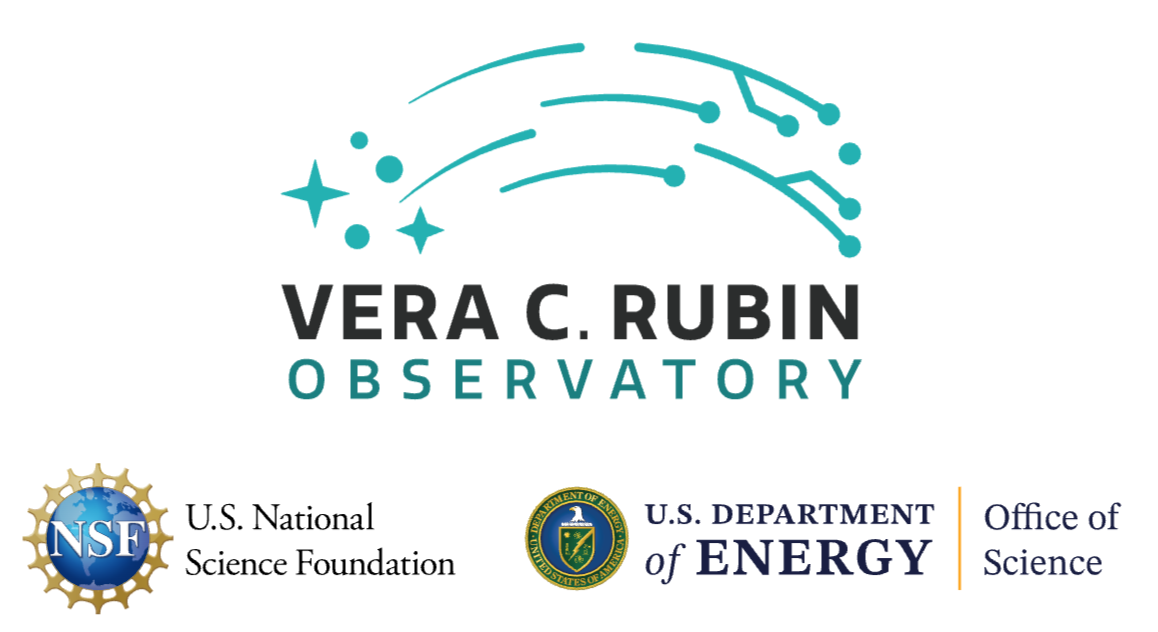
</div>
For the Rubin Science Platform at data.lsst.cloud. <br>
Data Release: DP1 <br>
Container Size: large <br>
LSST Science Pipelines version: r29.2.0 <br>
Last verified to run: 2025-09-02 <br>
Repository: <a href="https://github.com/lsst/tutorial-notebooks">github.com/lsst/tutorial-notebooks</a> <br>

**Learning objective:** How to use the Rubin image cutout service with DP1.

**LSST data products:** `visit_image`

**Packages:** `lsst.rsp.utils`, `pyvo`, `lsst.rsp.service`, `lsst.afw.display`

**Credit:** Originally developed by the Rubin Community Science team.
Please consider acknowledging them if this notebook is used for the preparation of journal articles, software releases, or other notebooks.

**Get Support:**
Everyone is encouraged to ask questions or raise issues in the 
<a href="https://community.lsst.org/c/support">Support Category</a> 
of the Rubin Community Forum.
Rubin staff will respond to all questions posted there.

## 1. Introduction

This notebook demonstrates how to use the image cutout service with DP1 images. The cutout service performs image cutouts remotely on the server using a protocol for remote data processing operations provided by the <a href="https://www.ivoa.net/">International Virtual Observatory Alliance (IVOA)</a>. 
The <a href="https://www.ivoa.net/">International Virtual Observatory Alliance (IVOA)</a> co-ordinates the community efforts of astronomical missions and archives to develop and maintain the Virtual Observatory (VO) standards. The VO standards enable interoperability between astronomical archives. 

IVOA provides the <a href="https://www.ivoa.net/documents/SODA/20170517/REC-SODA-1.0.html">Server-side Operations for Data Access (SODA)</a> protocol to provide these remote data processing operations. This protocol allows users to perform computations (pixel operations, image transformations, etc) on the remote server, which avoids unnecssary data movement. The LSST architecture has a "VO-first" approach, meaning that VO standards are implemented in all applicable services, enabling the use of VO tools such as the image cutout service to access LSST data. 

The procedure is to identify the remote web location of the image of interest (called a datalink), and use the web service to create a cutout from the linked data remotely, before transfering the cutout to the user on the Rubin Science Platform.

Further details and information can be found at <a href="https://www.ivoa.net/documents/DataLink/20211115/WD-DataLink-1.1-20211115.html"> the IVOA data link documentation</a>, where it says Access Data Services. Rubin-specific documentation for these can also be found in <a href="https://dmtn-238.lsst.io/">this document describing the RSP DataLink service implementation strategy</a>. 

To identify the remote location of the image, use Simple Image Access (SIA; see 100-level tutorial notebook on the SIA service). SIA is a protocol of the International Virtual Observatory Alliance (IVOA). It provides a standardized model for image metadata, and the capability to query and retrieve image datasets. Learn more in the [IVOA SIA documentation](https://www.ivoa.net/documents/SIA/).


**Related tutorials:** The 100-level tutorials on accessing images with the Simple Image Access (SIA) service, the Table Access Protocol (TAP) service, and the Butler.

### 1.1. Import packages

Import common scientific analysis packages `numpy` and `astropy`.

Import LSST Science Pipelines packages for image display `lsst.afw`, and utilities for remote data access `lsst.rsp`.

Import `pyvo` packages for working with the virtual observatory cutout service.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import lsst.afw.display as afwDisplay
from lsst.afw.image import ExposureF
from lsst.afw.fits import MemFileManager

from lsst.rsp.utils import get_pyvo_auth
from lsst.rsp.service import get_siav2_service

import lsst.geom as geom

from pyvo.dal.adhoc import DatalinkResults, SodaQuery

from astropy import units as u
from astropy.coordinates import Angle
from astropy.time import Time

### 1.2. Define parameters

Set the backend for `afwDisplay` to `matplotlib`.

In [ ]:
afwDisplay.setDefaultBackend('matplotlib')

### 1.3. Initiate the SIA service

SIAv2 is an IVOA standard for querying and retrieving image data from astronomical archives. This is used to retrieve a datalink that uniquely identifies DP1 images (in the format of a web URL identifying where the data is hosted).

Instantiate the SIA service. 

In [ ]:
service = get_siav2_service("dp1")
assert service is not None

## 2. Find the visit image

The cutout services needs the `access_url` for the image from which a cutout is desired.
The SIA or TAP services can be used to find the desired image and retrieve its `access_url`.

For this example, make an r-band (effective wavelength 622.1 nm) cutout centered on a set of coordinates in the ECDFS field,
for a visit image that was obtained between MJD 60623.256 and 60623.259.

Define the coordinates right ascension (`target_ra`) and declination (`target_dec`) in degrees.
Define the band and the start and end times.

In [ ]:
target_ra = 53.1246023
target_dec = -27.7404715
eff_wl = 622.1e-09
time1 = Time(60623.256, format="mjd", scale="tai")
time2 = Time(60623.259, format="mjd", scale="tai")

### 2.1. Query for images with SIA

It is recommended to tightly constrain image queries, so that they return only the image data products needed for a given scientific analysis.

Define the search position as a 0.05 degree circle, centered on the target.

In [ ]:
circle = (target_ra, target_dec, 0.05)

This query will return 1 `visit_image` (by design).

In [ ]:
results = service.search(pos=circle, calib_level=2, dpsubtype='lsst.visit_image',
                         band=eff_wl, time=(time1, time2))
print(len(results))

Display the results as an Astropy table.

In [ ]:
results.to_table()

In the table, the `access_url` contains the web URL datalink for the image. This datalink will be needed to generate the image cutout.

### 2.2. Query for images with TAP

It is also possible to get the `access_url` from the `ObsCore` table in the TAP service.

An example TAP query using this method that retrieves the `access_url` is:

```
SELECT dataproduct_type,dataproduct_subtype,calib_level,lsst_band,em_min,em_max,lsst_tract,lsst_patch,
       lsst_filter,lsst_visit,lsst_detector,t_exptime,t_min,t_max,s_ra,s_dec,s_fov,obs_id,
       obs_collection,o_ucd,facility_name,instrument_name,obs_title,s_region,access_url,
       access_format 
FROM ivoa.ObsCore 
WHERE CONTAINS(POINT('ICRS', 53.1567053, -27.7815854), s_region)=1
      AND obs_collection = 'LSST.DP1' AND calib_level = 2
      AND dataproduct_type = 'image' AND instrument_name = 'LSSTComCam'
      AND dataproduct_subtype = 'lsst.visit_image'
      AND ( t_min <= 60623.259 AND 60623.256 <= t_max )
      AND ( 622e-9 BETWEEN em_min AND em_max )
```

## 3. Generating an image cutout 

First, extract the datalink (access URL) from the first row of the results as `datalink_url`, using the `getdataurl` method. 

Next, provide authorization for the current RSP session, since the Rubin DP1 imaging is proprietary. Do this using the `get_pyvo_auth` function.

Finally, create a `DatalinkResults` object to be able to access this URL, which will be stored as `dl_result` and available for approximately 15 minutes, in a format that can be used by the IVOA tools below. The datalink is VOTable document, stored as `dl_result`.

In [ ]:
datalink_url = results[0].access_url
dl_result = DatalinkResults.from_result_url(datalink_url, session=get_pyvo_auth())

f"Datalink status: {dl_result.status}. Datalink service url: {datalink_url}"

Lastly, call the Rubin Image Cutout Service. This is the IVOA procedure `cutout-sync` that is called using `get_adhocservice_by_id`. It is done by feeding the data link created above (called `dl_result`) to `from_resource`. Since the Rubin DP1 imaging is proprietary it is necessary to again provide the authorization for the current RSP session. Do this using the `get_pyvo_auth` function.

In [ ]:
sq = SodaQuery.from_resource(dl_result,
                             dl_result.get_adhocservice_by_id("cutout-sync"),
                             session=get_pyvo_auth())

The variable `sq` now holds the result of the SODA query using the data link (which currently still points the full LSST `visit_image`, at its remote location in the database). The cell below will now demonstrate how to extract a cutout from `sq`.  

### 3.1. Define cutout center and edge

Only two shape definitions are supported: a circle function, and a polygon function can be used to define the cutout dimensions. These shape definitions do not produce circle or polygon cutouts, but rather are methods for defining the edges of cutouts with 4 sides. In the case of circle, the resulting cutout is always a square, with edge size that is the same as the circle diameter. In the case of a polygon, either a square or a rectangular cutout will result, depending on whether the length and width edge dimensions are different values. Only cutouts with 4 corners and 90 degree angles are supported. 

In [ ]:
spherePoint = geom.SpherePoint(target_ra*geom.degrees, target_dec*geom.degrees)
Radius = 0.01 * u.deg
sq.circle = (spherePoint.getRa().asDegrees() * u.deg,
             spherePoint.getDec().asDegrees() * u.deg,
             Radius)

### 3.2. Retrieve the cutout

The recommended method is to recieve the cutout into memory in the `ExposureF` format.

In [ ]:
cutout_bytes = sq.execute_stream().read()
sq.raise_if_error()
mem = MemFileManager(len(cutout_bytes))
mem.setData(cutout_bytes, len(cutout_bytes))
exposure = ExposureF(mem)

Display the cutout.

In [ ]:
display = afwDisplay.Display()
display.scale('asinh', 'zscale')
display.image(exposure.image)
plt.show()

> Figure 1: The cutout image, displayed in grayscale with a scale bar at right.

#### 3.2.1. Option to save cutout to disk

The cutout can be saved to disk as a FITS file with the `f.write()` function.

The cutouts saved to disk with the following commands will be stored in a temporary folder in the user's home directory.

After saving the cutout as a FITS file, read it in as an `ExposureF` and display it.

In [ ]:
# tempdir = os.path.join(os.getenv('HOME'), 'cutouts_temp/')
# if not os.path.exists(tempdir):
#     os.makedirs(tempdir)
#     print('Created ', tempdir)
# else:
#     print('Directory already existed: ', tempdir)

# sodaCutout = os.path.join(tempdir,'cutout-circle.fits')
# with open(sodaCutout, 'bw') as f:
#     f.write(sq.execute_stream().read())

# cutout = ExposureF(sodaCutout)
# display = afwDisplay.Display()
# display.scale('asinh', 'zscale')
# display.image(cutout.image)
# plt.show()

Future planned options for the Rubin cutout service, including the potential to retrieve other image formats such as jpeg, are listed at the <a href="https://dmtn-208.lsst.io/">Rubin Science Platform image cutout implementation strategy document</a>.


### 3.3. Use polygon to define shape

It is also possible to define the cutout geometry using a polygon, which enables the cutout to be rectangular, but not necessarily be square. For this, use `polygon`, which takes as input the four corners in celestial coordinates. A minimum of 3 vertices are required (the line from the last vertex back to the first is implicit) Vertices must be ordered in the counter-clockwise direction. For example: a polygon is defined as a set of 4 (x,y) coordinates from (12,34) to (14,34) to (14,36) to (12,36) and (implicitly) back to (12,34) as:

POLYGON=12 34 14 34 14 36 12 36

Since the center of the cutout is already defined in RA and Dec in the cells above (`spherePoint`), this example will define each x,y set as RA+/-edge and Dec+/-edge.

> **Warning:** Visit images are rotated, and although it is the "Declination edge" that is defined to be smaller, that corresponds to the x-axis when the cutout is displayed below, due to image rotation.

In [ ]:
sqp = SodaQuery.from_resource(dl_result,
                              dl_result.get_adhocservice_by_id("cutout-sync"),
                              session=get_pyvo_auth())

ra_edge = 0.02 * u.deg
de_edge = 0.005 * u.deg

sqp.polygon = (spherePoint.getRa().asDegrees() * u.deg - ra_edge,
               spherePoint.getDec().asDegrees() * u.deg - de_edge,
               spherePoint.getRa().asDegrees() * u.deg - ra_edge,
               spherePoint.getDec().asDegrees() * u.deg + de_edge,
               spherePoint.getRa().asDegrees() * u.deg + ra_edge,
               spherePoint.getDec().asDegrees() * u.deg + de_edge,
               spherePoint.getRa().asDegrees() * u.deg + ra_edge,
               spherePoint.getDec().asDegrees() * u.deg - de_edge)

cutout_bytes = sqp.execute_stream().read()
sqp.raise_if_error()
mem = MemFileManager(len(cutout_bytes))
mem.setData(cutout_bytes, len(cutout_bytes))
polygon = ExposureF(mem)

In [ ]:
display = afwDisplay.Display()
display.scale('asinh', 'zscale')
display.mtv(polygon.image)
plt.show()

> Figure 2: A rectangular polygon cutout from a rotated `visit_image`.

### 3.4. Correcting for cos(d)

There is an important difference to note between the circle and polygon shape definitions. The angular distance on the sky that defines the circular cutout size already accounts for the difference in angular distance in the RA direction is smaller by a factor of cos(declination), where declination is in units radians. The difference increases with higher declination. However, the polygon definition does not automatically account for this cosine factor. Thus, circle and polygon cutout definitions using the same cutout edge length will not match size in the RA direction. The 2 cells below demonstrate how to make this correction to the polygon cutout definition to create symmetric cutouts with polygon. Here, reset the edge sizes to be the same as `Radius` from the circle definition above.

First, generate a polygon cutout without factoring in cos(dec).

In [ ]:
sq2 = SodaQuery.from_resource(dl_result,
                              dl_result.get_adhocservice_by_id("cutout-sync"),
                              session=get_pyvo_auth())

edge1 = Radius
edge2 = Radius

sq2.polygon = (spherePoint.getRa().asDegrees() * u.deg - edge1,
               spherePoint.getDec().asDegrees() * u.deg - edge2,
               spherePoint.getRa().asDegrees() * u.deg - edge1,
               spherePoint.getDec().asDegrees() * u.deg + edge2,
               spherePoint.getRa().asDegrees() * u.deg + edge1,
               spherePoint.getDec().asDegrees() * u.deg + edge2)

cutout_bytes = sq2.execute_stream().read()
sq2.raise_if_error()
mem = MemFileManager(len(cutout_bytes))
mem.setData(cutout_bytes, len(cutout_bytes))
exposure2 = ExposureF(mem)

Second, generate a polygon cutout and includes the factor of cos(dec), to match the area generated by circle.

In [ ]:
a = Angle(spherePoint.getDec().asDegrees(), u.deg)
cosd = np.cos(a.radian)

sq3 = SodaQuery.from_resource(dl_result,
                              dl_result.get_adhocservice_by_id("cutout-sync"),
                              session=get_pyvo_auth())

sq3.polygon = (spherePoint.getRa().asDegrees() * u.deg - edge1/cosd,
               spherePoint.getDec().asDegrees() * u.deg - edge2,
               spherePoint.getRa().asDegrees() * u.deg - edge1/cosd,
               spherePoint.getDec().asDegrees() * u.deg + edge2,
               spherePoint.getRa().asDegrees() * u.deg + edge1/cosd,
               spherePoint.getDec().asDegrees() * u.deg + edge2,
               spherePoint.getRa().asDegrees() * u.deg + edge1/cosd,
               spherePoint.getDec().asDegrees() * u.deg - edge2)

cutout_bytes = sq3.execute_stream().read()
sq3.raise_if_error()
mem = MemFileManager(len(cutout_bytes))
mem.setData(cutout_bytes, len(cutout_bytes))
exposure3 = ExposureF(mem)

Plot the three cutouts as a comparison below. Setting `width_ratios` makes sure the y-axes (declination direction) span the same extent in the figure to emphasize that without the cos(dec) factor, the R.A. direction (x-axis) is truncated using polygon relative to circle.

In [ ]:
fig, ax = plt.subplots(1, 3, width_ratios=[0.35, 0.3, 0.35], figsize=(10, 14))

plt.sca(ax[0])
display1 = afwDisplay.Display(frame=fig)
display1.scale('linear', 'zscale')
display1.mtv(exposure.image, title='Cutout defined with circle')

plt.sca(ax[1])
display2 = afwDisplay.Display(frame=fig)
display2.scale('linear', 'zscale')
display2.mtv(exposure2.image, title='Cutout defined with polygon')

plt.sca(ax[2])
display3 = afwDisplay.Display(frame=fig)
display3.scale('linear', 'zscale')
display3.mtv(exposure3.image, title='Polygon including cos(dec)')
plt.tight_layout()
plt.show()

> Figure 3: A comparison of a cutout generated with the circle function (same as Figure 1; left panel) with a cutout defined using the `polygon` functionality defined using the same edge size (middle panel). The right panel uses `polygon` but accounts for the $cos({\rm dec})$ term, to replicate the same cutout that was made using circle.

The zooniverse package should be used instead of this procedure for citizen science applications. 

## 4. Exercise for the learner

Reproduce the cutout below, whose center is (ra, dec) = 59.1, -48.8 with 0.06 degrees on a side.

<div>
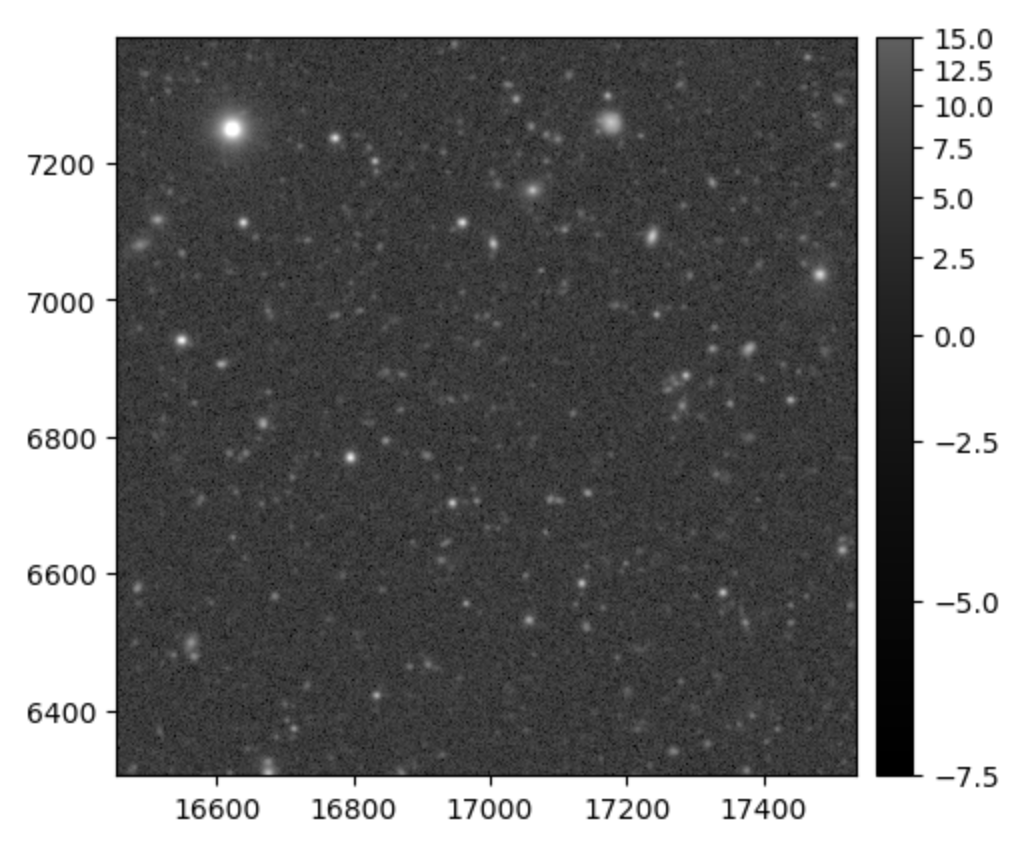
</div>